# Poisson Bootstrapping

How to perform poisson bootstraping, and the logic behind it.

### Setup

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
plt.style.use('../../default.mplstyle')

### Bootstrapping

Let's first review how bootstrapping works, before we go on to do poisson bootstrapping.

Bootstrapping is a nice way to estimate the confidence intervals of some metric without making too many assumptions about the distribution of that random variable.

So let's say you pull 1000 random variables from some distribution, and you take the mean of these numbers. You want to know the confidence interval of these numbers. So if you know the distribution you are pulling from you might be able to derive a nice formular based on variance that allows you to calculate the confidence intervals. If you are lucky are your distribution obeys the central limit theorem then you can very easily do this. But what if you know nothing about the distribution you are pulling from, or if the metric you are measuring is not a mean, maybe you're interested in the median, then CLT will not help you.

What you could do is pull the numbers from this distribution multiple times and look at the distribution of the numbers you get. In reality you might not be able to pull from the distribution 1000 times, the numbers that you have are all you are going to get. Bootstrapping allows you to simulate the effect of pulling many times from this distrubution many times, using only the numbers that you have.

The main idea with bootstrapping is that you sample the set of numbers that you have with replacement, to simulate the effects of sampling the original distrubution many times.

Let's try this with an example.

In our example we draw from a normal distribution. We can try other distributions at some point to test how much this matters.

Let's first generate some random numbers.

In [6]:
mean = 0.9
std = 0.6
N = 1000

data = np.random.normal(loc=mean, scale=std, size=N)

Now we take the mean of this data, this is our point estimate.

In [7]:
sample_mean = np.mean(data)

Because this is normally distributed we actually know the confidence interval. Later we can compute this as a comparison, but let's pretened that we don't actually know.

In [4]:
mean

0.9090243272869462

Now let's bootstrap this data. That means generating a random sample of this data with replacement, and taking the mean each time.

In [29]:
resample_size = 500
means_bootstrap = [np.mean(np.random.choice(data, size=N, replace=True)) for _ in range(resample_size)]

That's it. We've resampled our initial set of data with replacement many times, and taken the mean. So this distribution is an estimate of the distribution of our original metric.

(array([ 2.,  0.,  1.,  3.,  4., 12., 17., 35., 48., 56., 61., 65., 67.,
        54., 34., 20., 14.,  2.,  4.,  1.]),
 array([0.8188101 , 0.82515737, 0.83150464, 0.83785191, 0.84419918,
        0.85054644, 0.85689371, 0.86324098, 0.86958825, 0.87593551,
        0.88228278, 0.88863005, 0.89497732, 0.90132459, 0.90767185,
        0.91401912, 0.92036639, 0.92671366, 0.93306092, 0.93940819,
        0.94575546]),
 <BarContainer object of 20 artists>)

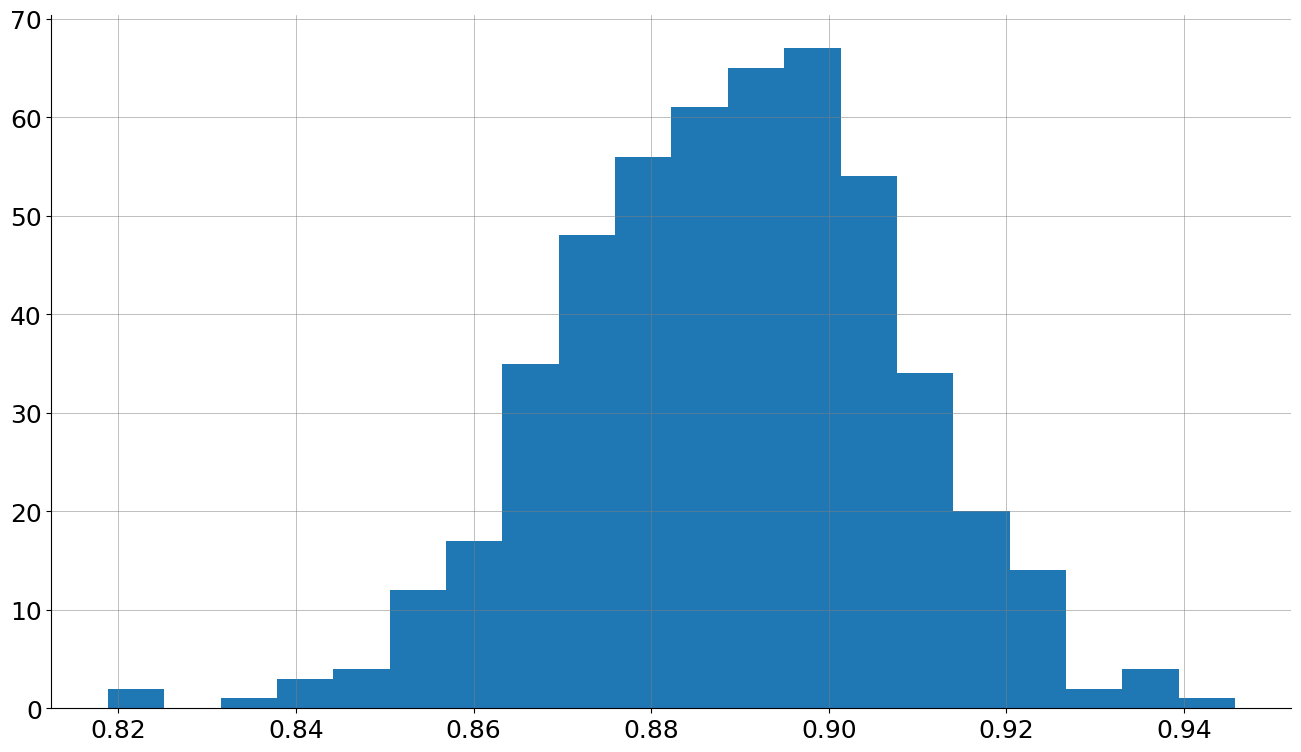

In [30]:
plt.hist(means_bootstrap, bins=int(resample_size/25))

Now our confidence intervals can be taken from this distribution. It depends on what level of confidence that you want of course. So you could find the 95% confidence interval by finding the upper and lower percentiles of 2.5%. Or you could take the standard deviation of these data to get the standard error.

Let's first do that.

In [32]:
bootstrap_error = np.std(means_bootstrap)
bootstrap_error

0.01879281250718009

The central limit theorem tells us that this should converge to the standard deviation of the original distribution divided by the root of the number of samples. Let's check this.

In [34]:
std/np.sqrt(N)

0.018973665961010275

It's pretty close! You can experiment with more bootstrap samples to check this.

Let's also get larger confidence intervals. What would they be?

Let's get the 90% confidence interval, by taking the 5th and 95th percentile of our data.

In [38]:
lb_90 = np.percentile(means_bootstrap, 5)
ub_90 = np.percentile(means_bootstrap, 95)
lb_90, ub_90

(0.8575510543984638, 0.9187720946541706)

Note that these CIs are not perfectly symetrical around our mean.

In [40]:
np.mean(means_bootstrap) - lb_90, ub_90 - np.mean(means_bootstrap)

(0.03143031833946153, 0.029790721916245322)

Although because we have a symetrical distribution, they are pretty close.

### Poisson Version

The poisson version aims to do something very similar. The main advantage is that it is more efficient in a parallel enviroment. The benefits will not be that apparent for this small data set on a single core. The point is that it will also give the same or similar results. But note that each row is processed independently, so in a mapreduce setting it could be fully distributed.

So the idea is that for each sample we sample each row a given number of times. On average this will be once. The number of times we sample each row is actually not independent, because we must always have the same number of rows in each sample. The core idea of poisson bootstrapping is that we ignore this interdependence, which is actually fine if we have quite a lot of data.

We simulate how many times each row is sampled in one bootstrap sample with a poisson distribution. In reality the real distribution is binomial, but for large numbers the binomial distribution approximates a possion distribution, with mean one.

Let's test this assumption numerically first by drawing the possion distribution against some bootstrapped samples.

let's pretend our data is the integers from 0 to 1000 (becuase we don't really care about their actual values, we just want to know how many times we sample them each time).

Let's resample our data many times and simply ask how many times each row is in the data. Actually all rows are sort of idential here, so let's arbitrarily ask how many times we sample the number 1 (but it could be anything).

In [53]:
data = list(range(N))
repeats = 50000
row_occurances = [list(np.random.choice(data, size=N, replace=True)).count(1) for _ in range(repeats)]

In [54]:
len(row_occurances)

50000

Note that this is a pretty inefficient way to get this result, but we don't care about that too much at this point.

(array([1.8457e+04, 1.8257e+04, 9.3290e+03, 3.0290e+03, 0.0000e+00,
        7.5800e+02, 1.5200e+02, 1.6000e+01, 1.0000e+00, 1.0000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

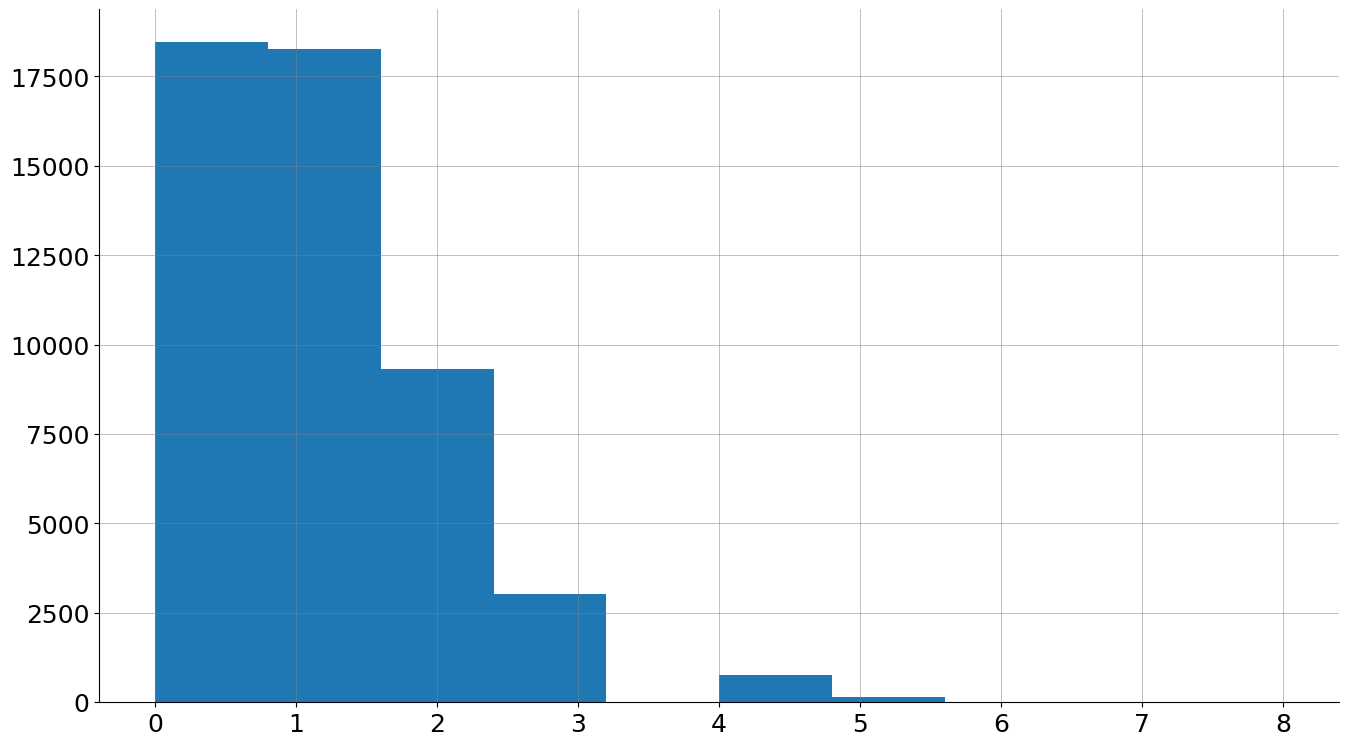

In [55]:
plt.hist(row_occurances)

So it often occurs that we get the row just once, often twice, but more times is quite rare.

The claim is that for large data the above distribution approximates poisson(1).

Let's test this numerically:

In [56]:
from scipy.stats import poisson

Recall that the mean should be one.

In [68]:
xs = np.linspace(0, 10, 1001)
ys = [poisson.pmf(k=x, mu=1) for x in xs]

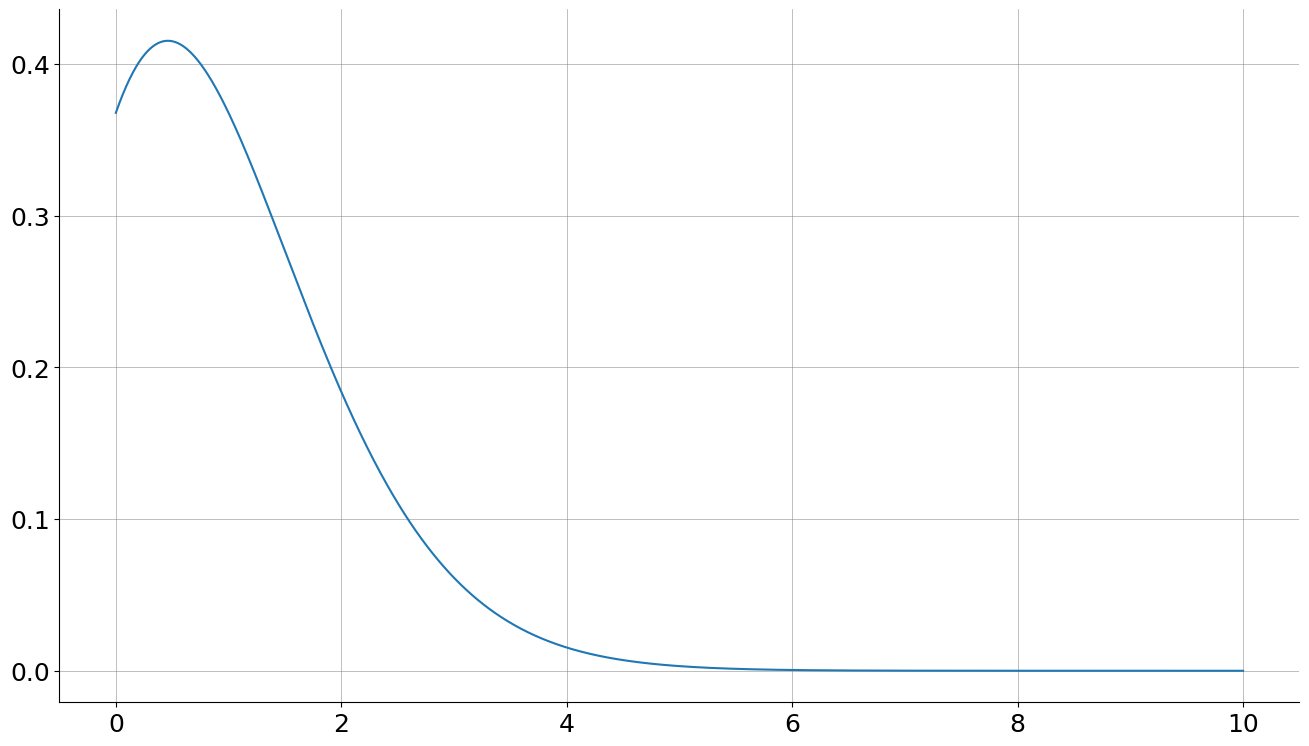

In [69]:
plt.plot(xs, ys)

Let's massage our data a little bit so that it is in the right format.

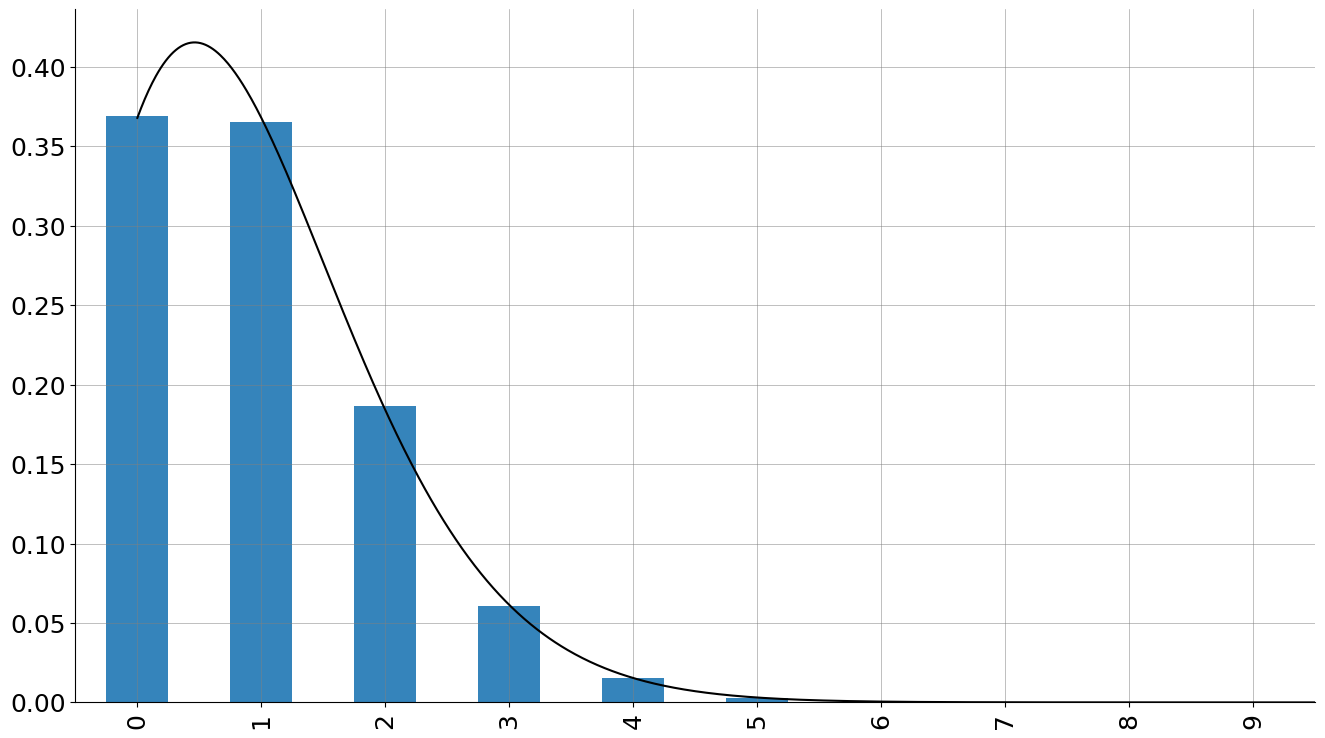

In [81]:
probs = {i: row_occurances.count(i)/repeats for i in range(10)}
ax = pd.Series(probs).plot.bar(alpha=0.9)
ax.plot(xs, ys, color='black')

So it goes nicely through the bars, although something slightly odd happens here for non-ingter values, but that's fine.

Now all of this gives us another way to generate a bootstrap sample. Instead of taking our data and resampling each time, we weight each sample by a random poisson number with mean 1, and take a weighted mean of this data. We still do it multiple times, so we havn't gained huge efficiencies, it should still be quicker, especially when parallelising.

So let's try this.

In [83]:
data = np.random.normal(loc=mean, scale=std, size=N)

In [119]:
poisson_bs_means = []
resample_size = 50000
for _ in range(resample_size):
    poissons = poisson.rvs(mu=1, size=N)
    total_samples = poissons.sum()
    poisson_bs_means.append(np.sum(poissons*data)/total_samples)

CPU times: user 3.88 s, sys: 5.58 ms, total: 3.88 s
Wall time: 3.88 s


So this gives us the same kind of thing. Statistically it's the same as bootstrapping, except that the total sample size is itself varies, but on average its the same, and for large numbers the variation will be quite small. So we simply ignore this wrinkle (we could more formally prove that it doesn't matter too much in principle).

Let's do the same comparisons that we did above for the standard bootstrapping procedure.

In [116]:
np.mean(poisson_bs_means)

0.9027647265075827

In [117]:
np.std(poisson_bs_means), std/np.sqrt(N)

(0.019239776051139162, 0.018973665961010275)

### Time comparison

Let's see how they compare timewise.

Do them both in a loop for a fair comparison.

In [126]:
def bootstrap(data, reps):
    
    N = len(data)
    means = []
    for _ in range(reps):
        sample = np.random.choice(data, size=N, replace=True)
        means.append(np.mean(sample))
    
    return means

In [129]:
def poisson_bootstrap(data, reps):
    
    N = len(data)
    means = []
    for _ in range(reps):
        poissons = poisson.rvs(mu=1, size=N)
        total_samples = poissons.sum()
        means.append(np.sum(poissons*data)/total_samples)

    return means


In [151]:
import time
bs_times = []
pbs_times = []

def time_it(fn, *args):
    tic = time.time()
    fn(*args)
    toc = time.time()
    return toc - tic

reps = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
for r in reps:
    print(r)
    bs_times.append(time_it(bootstrap, data, r))
    pbs_times.append(time_it(poisson_bootstrap, data, r))

500
1000
2000
5000
10000
20000
50000
100000
200000


In [152]:
df = pd.DataFrame({'bs_time': bs_times, 'pbs_times': pbs_times}, index=reps)

<AxesSubplot:>

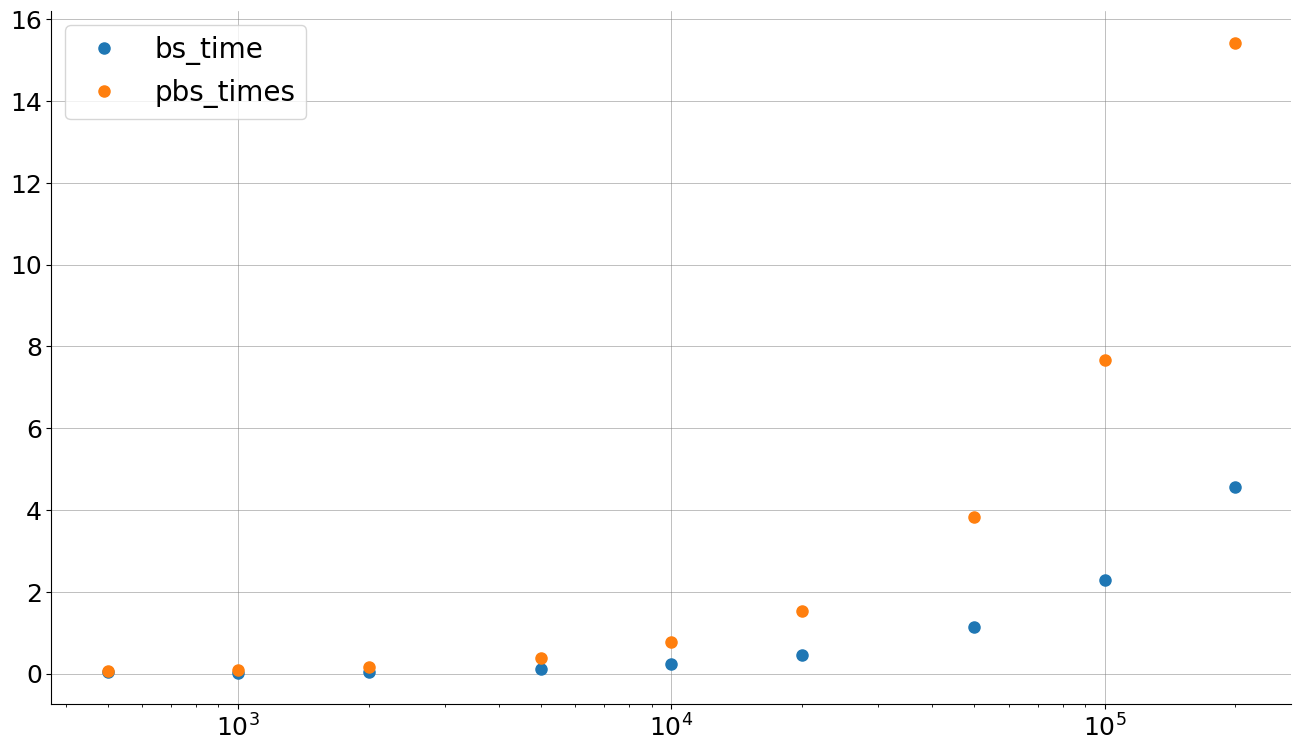

In [153]:
df.plot(logx=True, style='o')

So it's actually slower on one core, interesting. The advantage comes with parallelising.

### Bonus Question

Grouped poisson bootstrapping.

For extra efficiency we can do a little trick. If our data is not real numbers but something like integers, so that it is likely to be repeated we can group by the data and record how many times we see each data point. We then generate a poisson distribution for each data point, but instead of having mean 1, it has mean the number of times this row occured, and do the weighted distribution as we did before. Let's try this.

I'll generate random integers from 1 to 100, with 1000 samples, so that we are sure to have some repeated numbers.

In [154]:
data = np.random.randint(100, size=N)

In [157]:
np.mean(bootstrap(data, resample_size))

50.16900108

Now the way we do this will be slighlty more complicated, as we need to do a groupby, but note that this groupby happens only once, as it's the same data each time.

In [163]:
grouped_data = {i: list(data).count(i) for i in range(100)}

Now do the bootstrapping.

In [200]:
values = list(grouped_data.values())
keys = np.array(list(grouped_data.keys()))
means = []
for _ in range(resample_size):
    poissons = poisson.rvs(mu=values)
    total = poissons.sum()
    mean = (poissons*keys).sum()/total
    means.append(mean)

In [205]:
np.mean(means)

50.16857039804144

And note that although my input distribution is now uniform and not normal, it still obeys the central limit theorem.

In [212]:
np.std(means), np.std(data)/np.sqrt(N)

(0.9086672601503405, 0.9092350845628429)

Let's test the speed of this one as well.

In [213]:
def grouped_poisson_bs(data, reps):
    grouped_data = {i: list(data).count(i) for i in range(100)}
    values = list(grouped_data.values())
    keys = np.array(list(grouped_data.keys()))
    means = []
    for _ in range(reps):
        poissons = poisson.rvs(mu=values)
        total = poissons.sum()
        mean = (poissons*keys).sum()/total
        means.append(mean)
    return means

In [217]:
time_it(grouped_poisson_bs, data, 500)

0.07271289825439453

In [219]:
reps = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]
gpbs = []
for r in reps:
    print(r)
    gpbs.append(time_it(grouped_poisson_bs, data, r))

500
1000
2000
5000
10000
20000
50000
100000
200000


In [221]:
df = pd.DataFrame({'bs_time': bs_times, 'pbs_times': pbs_times, 'gpbs_times': gpbs}, index=reps)

In [222]:
df

,bs_time,pbs_times,gpbs_times
500,0.026040,0.052870,0.071651
1000,0.022793,0.075818,0.075227
2000,0.047038,0.154888,0.136028
5000,0.113887,0.381371,0.317932
10000,0.230053,0.768149,0.625682
20000,0.456332,1.526621,1.238278
50000,1.143804,3.838745,3.072160
100000,2.287558,7.662652,6.168877
200000,4.566929,15.428691,12.311927


<AxesSubplot:>

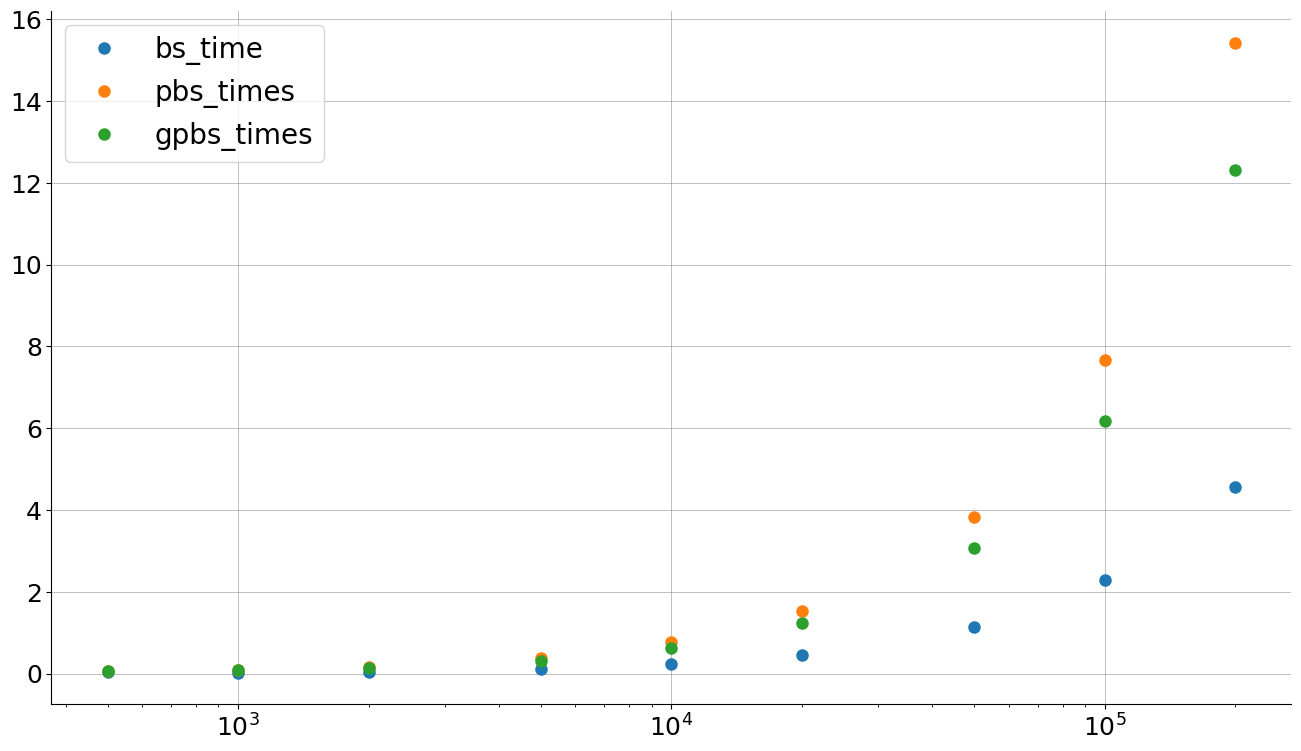

In [223]:
df.plot(logx=True, style='o')